# 데이터 불러오기

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from tqdm import tqdm

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Summary', 'Text']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Summary,Text
10562,Melted Morsels,Be sure the weather is cooler than 90 degrees ...
32574,These are the bomb!,So you don't want to spend $100/oz for truffle...
8005,Definitely delivers on relaxation,"The drink has a pleasant taste, especially whe..."
4080,"Not bad, not great",Icicle is a pretty good preamp for the price.<...
87462,a little consistency please?,i own two labs and a golden retriever and they...
44252,"Good, but pricey","This soup is easy to make, ready in a minute, ..."
64086,"How many t-discs in here, help?","I'd like to order this, but Amazon customer se..."
80303,Loved it!,After learning this was my boyfriends favorite...
33366,"Soft yes, but not very flavorful (B-)","These look good, and while they are soft, they..."
70626,nanas,"i have tryed the oatmeal, chocolate chip, coco..."


# 데이터 전처리

## (1) 데이터 정리하기

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


In [7]:
print(data.isnull().sum())

Summary    1
Text       0
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


### 텍스트 정규화와 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [14]:
# text 전처리하기


# clean_text = []

# for i in tqdm(range(data.shape[0])):
#     result = preprocess_sentence(data['Text'].values[i])
#     clean_text.append(result)
    
# len(clean_text), data.shape[0]

100%|██████████| 88425/88425 [13:08<00:00, 112.20it/s]


(88425, 88425)

In [15]:
# summary 전처리하기 

# clean_summary = []

# for i in tqdm(range(data.shape[0])):
#     result = preprocess_sentence(data['Summary'].values[i])
#     clean_summary.append(result)
    
# len(clean_summary), data.shape[0]

100%|██████████| 88425/88425 [01:07<00:00, 1304.46it/s]


(88425, 88425)

In [16]:
# data['Text'] = clean_text
# data['Summary'] = clean_summary

# # 빈 값을 Null 값으로 변환
# data.replace('', np.nan, inplace=True)
# print('=3')

=3


In [17]:
data.isnull().sum()

Summary    291
Text         0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88134


In [4]:
# 전처리한 데이터 저장하고 불러오기
import pickle

# save
# with open('./data/data.pickle', 'wb') as f:
#     pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# # load
# with open('./data/data.pickle', 'rb') as f:
#     data = pickle.load(f)

## (2) 훈련 데이터와 테스트 데이터 나누기

### 샘플의 최대 길이 정하기

In [5]:
# load
with open('./data/data.pickle', 'rb') as f:
    data = pickle.load(f)

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.796627862119045
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 2.871922300133887


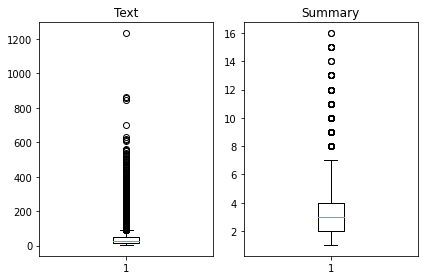

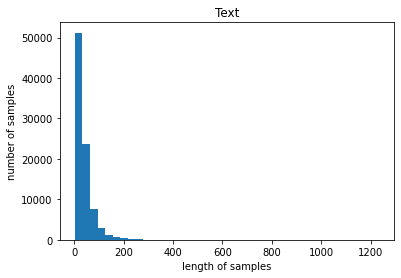

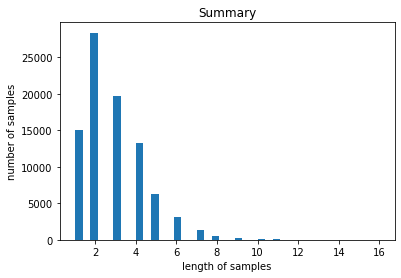

In [6]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [8]:
# 수작업으로 세주기
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [9]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745478475957065
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9944289377538748


In [10]:
# 데이터 자르기
data['Text'] = data['Text'].apply(lambda x: x if len(x.split()) <= text_max_len else np.nan)
data['Summary'] = data['Summary'].apply(lambda x: x if len(x.split()) <= summary_max_len else np.nan)

In [11]:
data = data.dropna()
data = data.reset_index(drop=True)

In [12]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,sostoken good quality dog food,good quality dog food eostoken
1,advertised,product arrived labeled jumbo salted peanuts p...,sostoken advertised,advertised eostoken
2,delight says,confection around centuries light pillowy citr...,sostoken delight says,delight says eostoken
3,cough medicine,looking secret ingredient robitussin believe f...,sostoken cough medicine,cough medicine eostoken
4,great taffy,great taffy great price wide assortment yummy ...,sostoken great taffy,great taffy eostoken


In [13]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [14]:
# 인덱스 섞기!

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

[59737 10965 21460 ... 31564 11021 50891]
=3


In [15]:
n_of_val = int(len(encoder_input)  *0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13610


In [16]:
# 훈련 / 테스트 나누기

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 54442
훈련 레이블의 개수 : 54442
테스트 데이터의 개수 : 13610
테스트 레이블의 개수 : 13610


## (3) 정수 인코딩

In [17]:
# 단어 집합(vocabulary) 만들기

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [18]:
# 빈도수 낮은 애들 빼주자

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수

rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32789
등장 빈도가 6번 이하인 희귀 단어의 수: 24372
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8417
단어 집합에서 희귀 단어의 비율: 74.32980572753057
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.34308330066981


In [19]:
src_vocab = 8000 # 전체 중 3프로 밖에 해당하지 않는 74%의 희귀 단어를 제외했을 때의 단어 집합의 크기
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [20]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[8, 2188, 1128, 6961, 2372, 3172, 8, 24, 200, 108, 19, 151, 196, 1, 2372, 3172, 8, 49, 262, 123, 42, 79, 209, 246, 826, 47, 22, 510, 142], [132, 2, 96, 42, 8, 339, 1253, 53, 96, 229, 19, 25, 2207, 226, 1253, 119, 44], [5, 354, 132, 7, 448, 122, 967, 306, 448, 296]]


In [21]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [22]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10875
등장 빈도가 5번 이하인 희귀 단어의 수: 8449
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2426
단어 집합에서 희귀 단어의 비율: 77.69195402298851
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.132599090285874


In [23]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 20, 160], [1, 35, 71], [1, 1064, 142], [1, 93, 9, 104, 1966], [1, 1445, 47, 19, 5, 246]]
target
decoder  [[20, 160, 2], [35, 71, 2], [1064, 142, 2], [93, 9, 104, 1966, 2], [1445, 47, 19, 5, 246, 2]]


In [24]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1750
삭제할 테스트 데이터의 개수 : 435
훈련 데이터의 개수 : 52692
훈련 레이블의 개수 : 52692
테스트 데이터의 개수 : 13175
테스트 레이블의 개수 : 13175


In [25]:
# Padding 하기

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


In [ ]:
# 이 과정 함수로 정리하기
def get_input_target_train_test():
    

## 모델 설계하기


In [27]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len, ))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

In [29]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [30]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 50, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

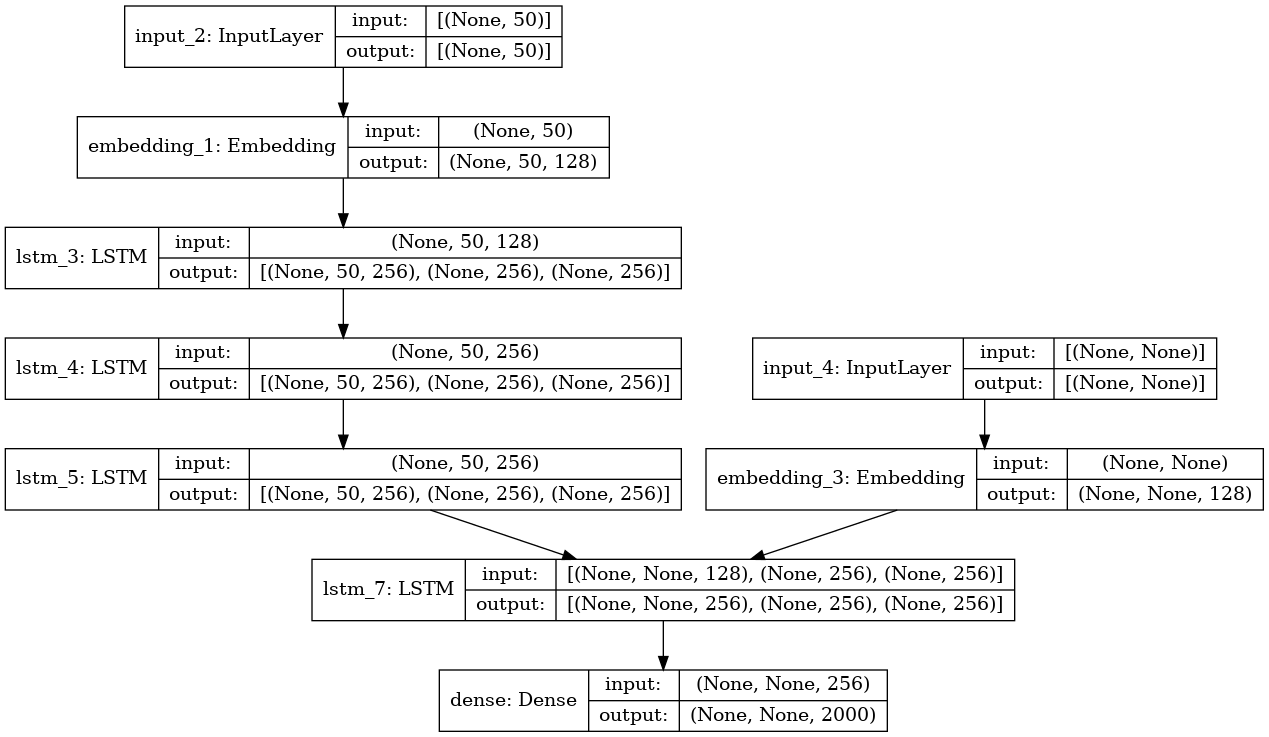

In [32]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True)

어텐션 메커니즘

In [34]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 50, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

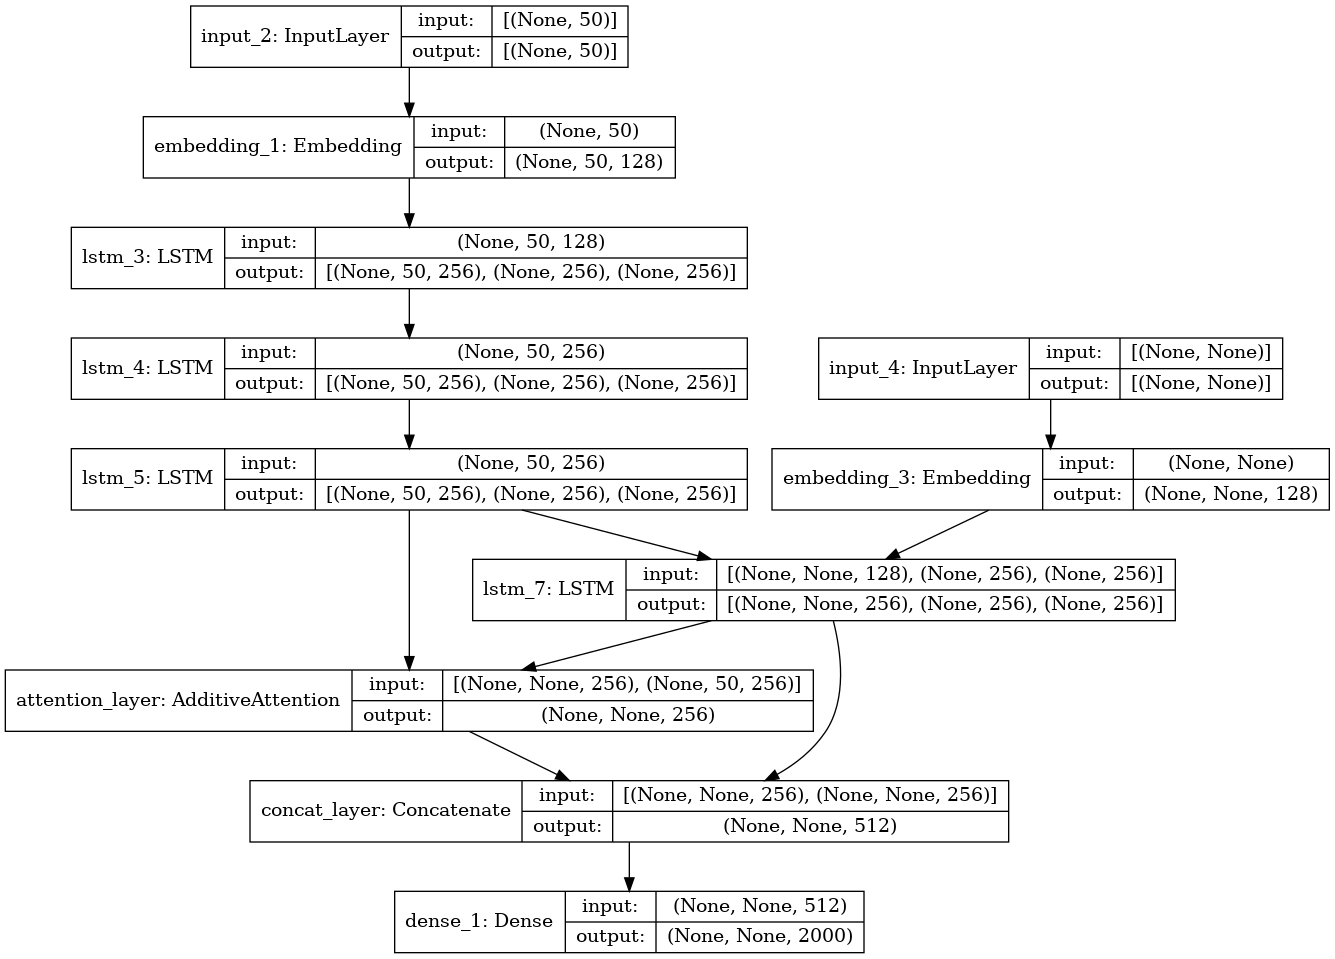

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 모델 훈련하기

In [36]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
206/206 [==============================] - 43s 144ms/step - loss: 2.1965 - val_loss: 1.9434
Epoch 2/50
206/206 [==============================] - 30s 144ms/step - loss: 1.9223 - val_loss: 1.8445
Epoch 3/50
206/206 [==============================] - 30s 144ms/step - loss: 1.8369 - val_loss: 1.7737
Epoch 4/50
206/206 [==============================] - 29s 142ms/step - loss: 1.7680 - val_loss: 1.7331
Epoch 5/50
206/206 [==============================] - 30s 143ms/step - loss: 1.7182 - val_loss: 1.7042
Epoch 6/50
206/206 [==============================] - 30s 144ms/step - loss: 1.6799 - val_loss: 1.6800
Epoch 7/50
206/206 [==============================] - 30s 143ms/step - loss: 1.6435 - val_loss: 1.6619
Epoch 8/50
206/206 [==============================] - 29s 143ms/step - loss: 1.6094 - val_loss: 1.6471
Epoch 9/50
206/206 [==============================] - 29s 143ms/step - loss: 1.5783 - val_loss: 1.6365
Epoch 10/50
206/206 [==============================] - 29s 143ms/step - l

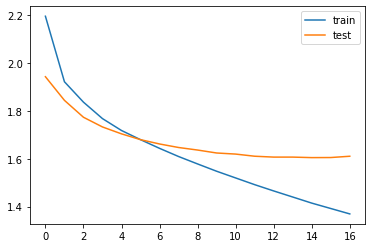

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기

In [38]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


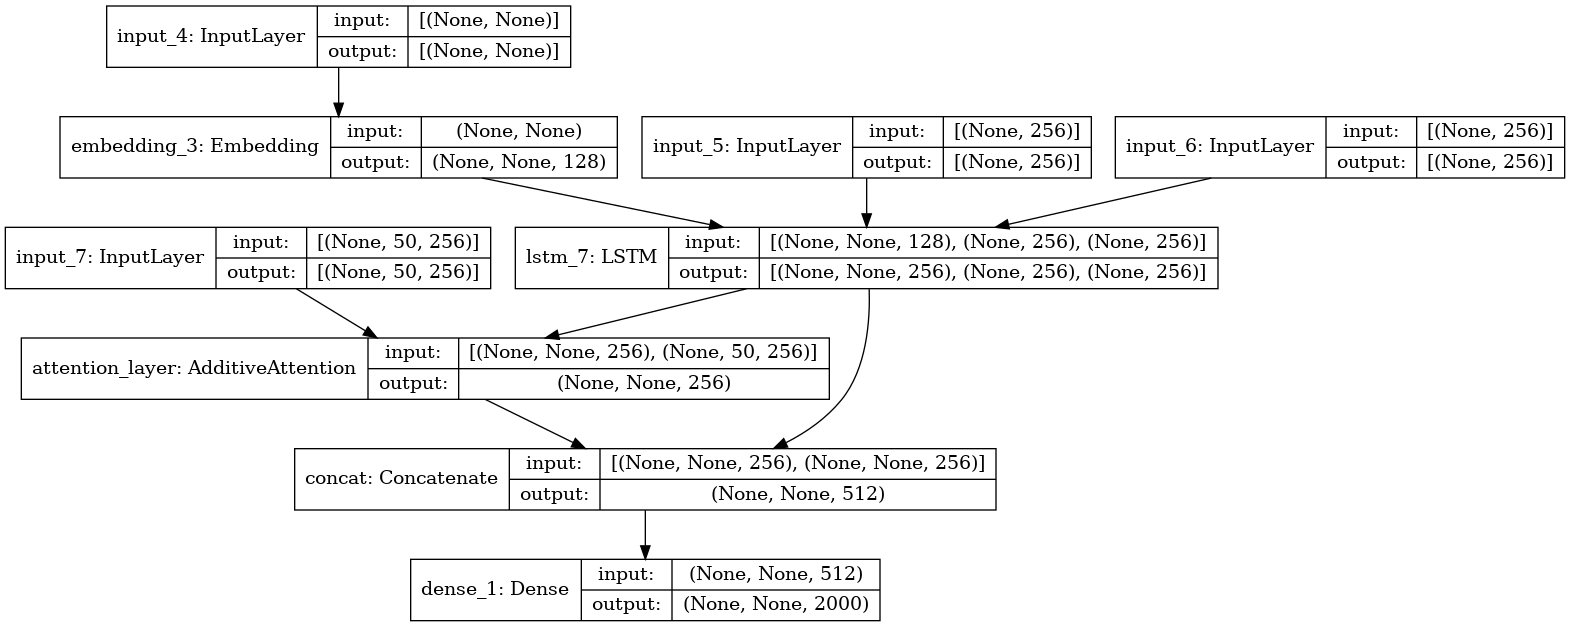

In [46]:
tf.keras.utils.plot_model(decoder_model, show_shapes=True)

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


# 모델 테스트 하기

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
# 0은 padding에서 사용된 숫자
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
# Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 and i != 1 and i != 2):
            temp = temp + src_index_to_word[i]+' '
        
    return temp

print('=3')

=3


In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : great snack bought try ordering taste somewhat like cross jack parmesan cheese get sized fat discs crispy baked cheese salty love 
실제 요약 : broken eating make 
예측 요약 :  great snack


원문 : thought would interesting combo introduce daughter learned hard convince mo eat curry hate cannot get eat like flavors maybe try older hit 
실제 요약 : even taste lot tasty price 
예측 요약 :  good


원문 : unique packaging delivers better cup coffee cannot beat cost per cup friends love reorder sure 
실제 요약 : hot eaten grams sugar great tea 
예측 요약 :  great coffee


원문 : two increasingly finicky cats approved faith purchase newman organics chicken brown rice formula cleaning bowls 
실제 요약 : since nicely 
예측 요약 :  cats love


원문 : granny convenient sweet food delivered door sometimes bit challenge get store 
실제 요약 : always much 
예측 요약 :  great product


원문 : find even gain maximum volume loud use mic one must close speak somewhat use mixer volume problems simple set almost plug play choose source 
실제 요약 : almo

예측 요약 :  great stuff


원문 : opened latest order appears recipe changed cannot taste peanut butter tastes sweet 
실제 요약 : amazon beat 
예측 요약 :  good


원문 : couple weeks dog food became ill bad got worse worse getting night blood since happened heard happening dogs big risk ingredients right result extremely bad 
실제 요약 : much fresh really please 
예측 요약 :  dog


원문 : dog pickiest eater enjoy many treats goes crazy one helps freshen breath know cleaning ability product bad thing make dog fat eats much 
실제 요약 : great awesome delighted 
예측 요약 :  dog loves


원문 : delivered quickly bought grain free dog however care think kibble rather small aroma salmon based foods donating remainder animal rescue group 
실제 요약 : fact great much 
예측 요약 :  dog likes


원문 : given sweetleaf choc totally different taste usual one buy says ask care packaging different probably means ingredients different ordering unless replaced usual sorry 
실제 요약 : tea 
예측 요약 :  bad


원문 : big sodas like pomegranate juice thought w

# 추출적 요약 해보기

In [50]:
import requests
from summa.summarizer import summarize

In [51]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [52]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [53]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [54]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [55]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
